# 9.5. 콘텐츠 기반 필터링 실습 - TMDB 5000 영화 데이터 세트

- TMDB 5000: 영화 데이터 정보 사이트인 IMDB의 많은 영화 중 주요 5000개 영화에 대한 메타 정보를 새롭게 가공해 캐글에서 제공하는 데이터 세트


**장르 속성을 이용한 영화 콘텐츠 기반 필터링**
- 콘텐츠 기반 필터링

  : 사용자가 특정 영화를 감상하고 그 영화를 좋아했다면 그 영화와 비슷한 특성/속성, 구성 요소 등을 가진 다른 영화를 추천하는 것
  - 영화(또는 상품/서비스) 간의 유사성을 판단하는 기준이 영화를 구성하는 다양한 콘텐츠(장르, 감독, 배우, 평점, 키워드, 영화 설명)을 기반으로 하는 방식
- 영화 장르 속성을 기반으로

  => 장르 칼럼 값의 유사도를 비교한 뒤 그중 높은 평점을 가지는 영화를 추천하는 방식

## 데이터 로딩 및 가공

### 데이터 로딩

In [ ]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies = pd.read_csv('/content/tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


- 4803개의 레코드롸 20갸의 피처로 구성
- 영화 제목, 개요, 인기도, 평점, 투표 수, 예산, 키워드 등 영화에 대한 다양한 메타 정보

### 주요 칼럼 추출
- id, 영화제목 title, 영화가 속한 여러 가지 장르인 genres, 평균 평점 vote_average, 평점 투표 수 vote_count, 영화의 인기를 나타내는 popularity, 영화를 설명하는 주요 키워드 문구 keywords, 영화에 대한 개요 설명인 overview

In [ ]:
movies_df = movies[['id', 'title', 'genres', 'vote_average', 'vote_count', 'popularity', 'keywords', 'overview']]

### 딕셔너리 형태의 데이터 처리

- 'genres', 'keywords'

  : 파이썬 리스트 내부에 여러 개의 딕셔너리가 있는 형태의 문자열로 표기

  => dataframe으로 만들어질 때는 단순히 문자열로 로딩

  => 이 칼럼을 가공해야 필요한 정보를 추출할 수 있음

#### 칼럼의 형태 확인

In [ ]:
# 칼럼의 형태 확인
pd.set_option('max_colwidth', 100)
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


- genres, keywords 칼럼: 여러 개의 개별 장르 데이터를 가지고 있음

  => 이 개별 장르의 명칭은 딕셔너리의 키인 'name'으로 추출할 수 있음

#### 칼럼의 문자열을 분해해서 개별 장르, 키워드를 파이썬 리스트 객체로 추출

- 칼럼의 문자열을 분해해서 개별 장르를 파이썬 리스트 객체로 추출
- 파이썬 ast 모듈의 literal_eval( )함수를 이용

  => 문자열을 문자열이 의미하는 list[dict1, dict2] 객체로 만들 수 있음
- Series 객체의 apply( )에 literal_eval 함수를 적용해 문자열을 객체로 변환

In [ ]:
# 칼럼의 문자열을 분해해서 개별 장르를 파이썬 리스트 객체로 추출
from ast import literal_eval

movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

#### 장르명, 키워드만 리스트 객체로 추출
- genres 칼럼에서 'name' 키에 해당하는 값을 추출하기 위해 apply lambda 식을 이용
- apply(lambda x: [y['name'] for y in x])

  => 리스트 내 여러 개의 딕셔너리의 'name'키에 해당하는 값을 찾아 이를 리스트 객체로 변환

In [ ]:
movies_df['genres'] = movies_df['genres'].apply(lambda x: [y['name'] for y in x])
movies_df['keywords']  = movies_df['keywords'].apply(lambda x: [y['name'] for y in x])

movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


## 장르 콘텐츠 유사도 측정
- genres 칼럼은 여러 개의 개별 장르가 리스트로 구성되어 있음

  => genres를 문자열로 변경한 뒤 이를 CountVecotizer로 피처 벡터화한 행렬 데이터 값을 코사인 유사도로 비교

**< genres 칼럼을 기반으로 하는 콘텐츠 기반 필터링 >**
1. 문자열로 변환된 genres 칼럼을 Count 기반으로 피처 벡터화 변환
2. genres 문자열을 피처 벡터화 행렬로 변환한 데이터 세트를 코사인 유사도를 통해 비교. 이를 위해 데이터 세트의 레코드별로 타 레코드롸 장르에서 코사인 유사도 값을 가지는 객체를 생성
3. 장르 유사도가 높은 영화 중에 평점이 높은 순으로 영화를 추천

### 칼럼 문자열 변환, 피처 벡터화 변환
- 리스트 객체 값으로 구성된 genres 칼럼을 apply(lambda x: (' ').join(x))를 적용해 개별 요소를 공백 문자로 구분하는 문자열로 변환 -> 별도의 칼럼인 genres_listeral 칼럼으로 저장
- 리스트 객체 내의 개별 값을 연속된 문자열로 변환하려면 일반적으로 ('구분문자').join(리스트 객체)를 사용

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x: (' ').join(x))
count_vect = CountVectorizer(min_df = 0.0, ngram_range = (1, 2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


### 코사인 유사도 확인
- cosine_similarity( ): 기준 행과 비교 행의 코사인 유사도를 행렬 형태로 반환하는 함수

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:1])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]]


- genre_sim: movies_d의 genre_literal 칼럼을 피처 벡터화한 행렬(genre_mat) 데이터의 레코드별 유사도 정도를 가지고 있음

  => movies_df dataframe의 행별 장르 유사도 값을 가지고 있는 것

  => movies_df를 장르 기준으로 콘텐츠 기반 필터링을 수행하려면 movies_df의 개별 레코드에 대해서 가장 장르 유사도가 높은 순으로 다른 레코드를 추출해야함

### 장르 유사도가 높은 순으로 레코드 추출
- genre_sim 객체를 이용
- genre_sim 객체의 기준 행별로 비교 대상이 되는 행의 유사도 값이 높은 순으로 정렬된 행렬의 위치 인덱스 값을 추출
- 넘파이 argsort( ) 함수를 이용

  => argdort( )[:, ::-1]를 사용해 높은 순으로 정렬된 비교 행 위치 인덱스 값을 가져옴

In [ ]:
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1]) # 0번 레코드의 비교 행 위치 인덱스 값만 샘플로 추출

[[   0 3494  813 ... 3038 3037 2401]]


- [[   0 3494  813 ... 3038 3037 2401]: 0번 레코드의 경우, 자신인 0번 레코드를 제외하면 3494번 레코드가 가장 유사도가 높고 그 다음이 813번 레코드이며 가장 유사도가 낮은 레코드는 2401번 레코드라는 뜻
- genre_sim_sorted_ind: 각 레코드의 장르 코사인 유사도가 가장 높은 순으로 정렬된 타 레코드의 위치 인덱스 값을 가지고 있음

  => 이 위치 인덱스를 이용해 언제든지 특정 레코드와 코사인 유사도가 높은 다른 레코드를 추출할 수 있음

## 장르 콘텐츠 필터링을 이용한 영화 추천

### 장르 유사도에 따라 영화를 추천하는 함수 생성
- 함수명: find_sim_movie( )
- 인자: 기반 데이터인 movied_df, 레코드별 장르 코사인 유사도 인덱스를 가지고 있는 genre_sim_sorted_ind, 고객이 선정한 추천 기준이 되는 영화 제목, 추천할 영화 건수
- 반환: 추천 영화 정보를 가지는 dataframe

In [ ]:
def find_sim_movie(df, sorted_ind, title_name, top_n = 10):
  # 인자로 입력된 movies_df DataFrame에서 'title' 칼럼이 입력된 title_name 값인 dataframe 추출
  title_movie = df[df['title'] == title_name]

  # title_named을 가진 datafrmae의 index 객체를 ndarray로 반환하고
  # sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n개의 index 추출
  title_index = title_movie.index.values
  similar_indexes = sorted_ind[title_index, :(top_n)]

  # 추출된 top_n index 출력. top_n index 2차원 데이터임
  # dataframe에서 index로 사용하기 위해서 1차원 array로 변경
  print(similar_indexes)
  similar_indexes = similar_indexes.reshape(-1)

  return df.iloc[similar_indexes]

### 영화 '대부'와 유사한 영화 10개 추천
- find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10) 호출

In [ ]:
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


- 평점이 낮은 영화도 추천하는 결과가 나타남

### 더 많은 후보군을 선정한 후 영화의 평점에 따라 필터링해서 최종 추천하는 방식
- 영화의 평점 정보 'vote_average'값 이용

  => 0~10점 만점의 점수로 구성, 소수의 관객이 평가한 경우 점수가 왜곡될 수 있음

#### vote_average 왜곡값 확인
- sort_values( ) 이용해서 평점 오름차순으로 movies_df 정렬

In [ ]:
movies_df[['title', 'vote_average', 'vote_count']].sort_values('vote_average', ascending = False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


- 처음 보는 영화가 유명한 명작보다 더 높은 순위에 있음

  => 모두 평가 횟수가 매우 작음
- 왜곡된 평점 데이터를 회피할 수 있도록 평점에 평가 횟수를 반영할 수 있는 새로운 평가 방식이 필요함

#### 새로운 평가 방식
- 영화 평점 사이트 IMDB에서는 평가 횟수에 대한 가중치가 부여된 평점 방식을 사용


```
가중 평점 = (v / (v+m)) * R + (m / (v+m)) * C

v: 개별 영화에 평점을 투표한 횟수
m: 평점을 부여하기 위한 최소 투표 횟수
R: 개별 영화에 대한 평균 평점
C: 전체 영화에 대한 평균 평점
```
- v: movie_df의 'vote_count' 값
- R: 'vote_average' 값
- m: 투표 횟수에 따른 가중치를 조절, m값을 높이면 평점 투표횟수가 많은 영화에 더 많은 가중 평점을 부여

  => 전체 투표 횟수에서 상위 60%에 해당하는 횟수를 기준으로 정함. 상위 60% 값은 Series 객체의 quantile( )을 이용해 추출




In [ ]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)
print('C: ', round(C, 3), 'm: ', round(m, 3))

C:  6.092 m:  370.2


#### 기존 평점을 새로운 가중평점으로 변경하는 함수 생성, 새로운 평점 정보 생성
- 함수 명: weighted_vote_average( )

  - DataFrame의 레코드를 인자로 받아 이 레코드의 vote_count, vote_average 칼럼, 레코드별 가중 평점을 반환
  - 함수를 movies_df의 apply( )함수의 인자로 입력해 가중 평점을 계산

In [ ]:
percentile = 0.6
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(percentile)

def weighted_vote_average(record):
  v = record['vote_count']
  R = record['vote_average']

  return ((v / (v+m)) * R) + ((m / (v+m)) * C)

movies_df['weighted_vote'] = movies_df.apply(weighted_vote_average, axis = 1)

#### 가중평점이 높은 순으로 상위 10개 영화 추출

In [ ]:
movies_df[['title', 'vote_average', 'weighted_vote', 'vote_count']].sort_values(
    'weighted_vote', ascending = False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


#### 가중평점에 따라 영화 추천
- '장르 유사성이 높은 영화를 top_n의 2배수만큼 후보군으로 선정 -> weighted_vote 칼럼이 높은 순으로 top_n만큼 추출' 방식으로 find_sim_movie( ) 함수를 변경
- 변경된 find_sim_movie( )를 이용해 '대부'와 유사한 영화를 콘텐츠 기반 필터링 방식으로 추천

In [ ]:
def find_sim_movie(df, sorted_ind, title_name, top_n = 10):
  title_movie = df[df['title'] == title_name]
  title_index = title_movie.index.values

  # top_n의 2배에 해당하는 장르 유사성이 높은 인덱스 추출
  similar_indexes = sorted_ind[title_index, :(top_n*2)]
  sililar_indexes = similar_indexes.reshape(-1)

  # 기준 영화 인덱스는 제외
  similar_indexes = similar_indexes[similar_indexes != title_index]

  # top_n의 2배에 해당하는 후보군에서 weighted_vote가 높은 순으로 top_n만큼 추출
  return df.iloc[similar_indexes].sort_values('weighted_vote', ascending = False)[:top_n]

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average', 'weighted_vote']]

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427


# 9.6. 아이템 기반 최근접 이웃 협업 필터링 실습
- 최근접 이웃 협업 필터링: 사용자 기반, 아이템 기반
- 아이템 기반의 협업 필터링: 추천 정확도가 더 뛰어남

- 협업 필터링 기반의 영화 추천을 위해서는 사용자가 영화의 평점을 매긴 사용자-영화 평점 행렬 데이터 세트가 필요

## 데이터 가공 및 변환


### 데이터 로딩

In [7]:
import pandas as pd
import numpy as np

movies = pd.read_csv('/content/movies.csv')
ratings = pd.read_csv('/content/ratings.csv')

print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


- movies.csv: 영화에 대한 메타 정보인 title, genres를 가지고 있는 영화 정보
- ratings.csv: 사용자별로 영화에 대한 평점을 매긴 데이터 세트
  - userId: 사용자 아이디
  - movieId: 영화(아이템) 아이디
  - rating: 평점, 0.5~5 사이, 0.5 단위
  - timestamp: 의미 없는 칼럼




### 데이터 가공

#### pivot_table( )

**< 아이템 기반의 최근접 이웃 협업 필터링 >**

* rating.csv의 dataframe인 ratings 이용
* 우선 로우(행) 형태의 원본 데이터 세트를 모든 사용자를 로우로, 모든 영화를 칼럼으로 구성한 데이터 세트로 변경
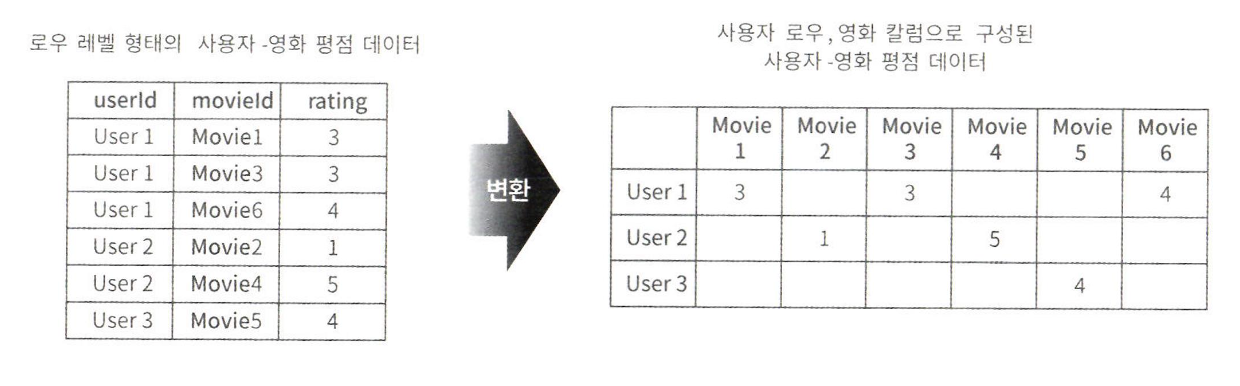

- DataFrame의 pivot_table( )함수 이용

  - 로우 레벨의 값을 칼럼으로 변경하는 데 효과적
  - 인자로 columns = 'movieId'를 부여하면, movieId 칼럼의 모든 값이 새로운 칼럼으로 변환
  
- ratings.pivot_table('rating', index = 'userId', columns = 'movieId') 호출
  - 로우(행) 레벨은 userId
  - 칼럼은 모두 movieId 칼럼에 있는 값으로 칼럼 이름이 바뀜
  - 데이터는 rating 칼럼에 있는 값이 할당


In [8]:
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index = 'userId', columns = 'movieId')
ratings_matrix.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 칼럼명 변경, 결측치 처리
- 가독성을 위해 칼럼명을 movieId -> title
  - title은 ratings가 아닌 movies 데이터 세트에 존재
  - ratings, movies를 조인 -> title 칼럼 가져오기 -> pivot_table( )의 인자로 columns에 'title' 입력해 title로 pivot
- 결측치를 0으로 변환

In [9]:
# title 칼럼을 얻기 위해 movies와 조인
rating_movies = pd.merge(ratings, movies, on = "movieId")

# columns = 'title'로 title 칼럼으로 피벗 수행
ratings_matrix = rating_movies.pivot_table('rating', index = 'userId', columns = 'title')

# NaN 값을 모두 0으로 변환
ratings_matrix = ratings_matrix.fillna(0)

ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 영화 간 유사도 산출
- 변환된 사용자-영화 평점 행렬 데이터 세트를 이용해 영화 간의 유사도 측정
- 영화 간의 유사도는 코사인 유사도를 기반으로 함
- 사이킷런의 cosine_similarity( )를 이용하여 측정

### 행과 열 traspose
- 현재의 ratings_matrix 데이터 세트에 cosine_similarity( )를 적용하면 영화 간의 유사도가 아닌 사용자 간의 유사도를 산출함

- 영화를 기준으로 cosine_similarity( )를 적용하려면 ratings_matrix의 행과 열을 바꿔야 함
  
  => tranpose( ) 적용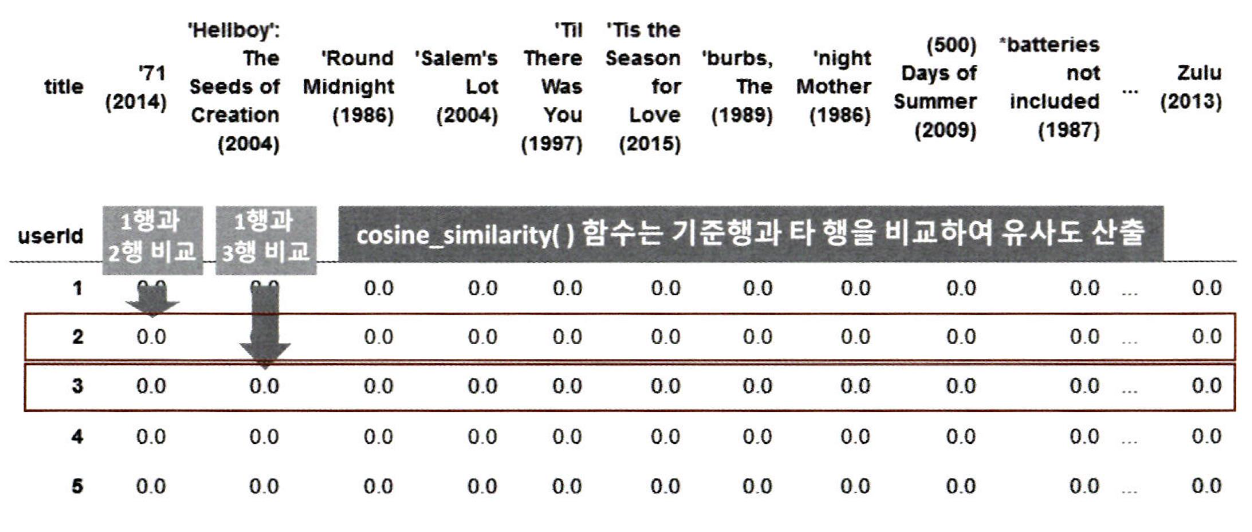

In [10]:
ratings_matrix_T = ratings_matrix.transpose()

ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 영화의 코사인 유사도 산출
- 변경한 데이터 세트를 기반으로 영화의 코사인 유사도 구하기
- 직관적인 영화의 유사도 값을 표현하기 위해 cosine_similarity( )로 반환된 넘파이 행렬에 영화명을 매핑해 DataFrame으로 변환

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity( )로 반환된 넘파이 행렬을 영화명에 매핑해 DF로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_matrix.columns, columns=ratings_matrix.columns)

print(item_sim_df.shape)
item_sim_df.head(3)

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.0,0.0,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


### 영화 '대부'와 유사도가 높은 상위 6개 영화 추천

In [12]:
item_sim_df["Godfather, The (1972)"].sort_values(ascending=False)[:6]

,"Godfather, The (1972)"
title,
"Godfather, The (1972)",1.000000
"Godfather: Part II, The (1974)",0.821773
Goodfellas (1990),0.664841
One Flew Over the Cuckoo's Nest (1975),0.620536
Star Wars: Episode IV - A New Hope (1977),0.595317
Fargo (1996),0.588614


### 영화 '인셉션'과 유사도가 높은 영화 추천
- 자신은 유사도에서 제외

In [13]:
item_sim_df["Inception (2010)"].sort_values(ascending=False)[1:6]

,Inception (2010)
title,
"Dark Knight, The (2008)",0.727263
Inglourious Basterds (2009),0.646103
Shutter Island (2010),0.617736
"Dark Knight Rises, The (2012)",0.617504
Fight Club (1999),0.615417


- 만들어진 아이템 기반 유사도 데이터는 사용자의 평점 정보를 모두 취합해 영화에 따라 유사한 다른 영화를 추천할 수 있게 해줌

## 아이템 기반 최근접 이웃 협업 필터링으로 개인화된 영화 추천
- 개인이 아직 관람하지 않은 영화를 추천
- 아직 관람하지 않은 영화에 대해서 아이템 유사도와 기존에 관람한 영화의 평점 데이터를 기반으로 해 새롭게 모든 영화의 예측 평점을 계산한 후 높은 예측 평점을 가진 영화를 추천
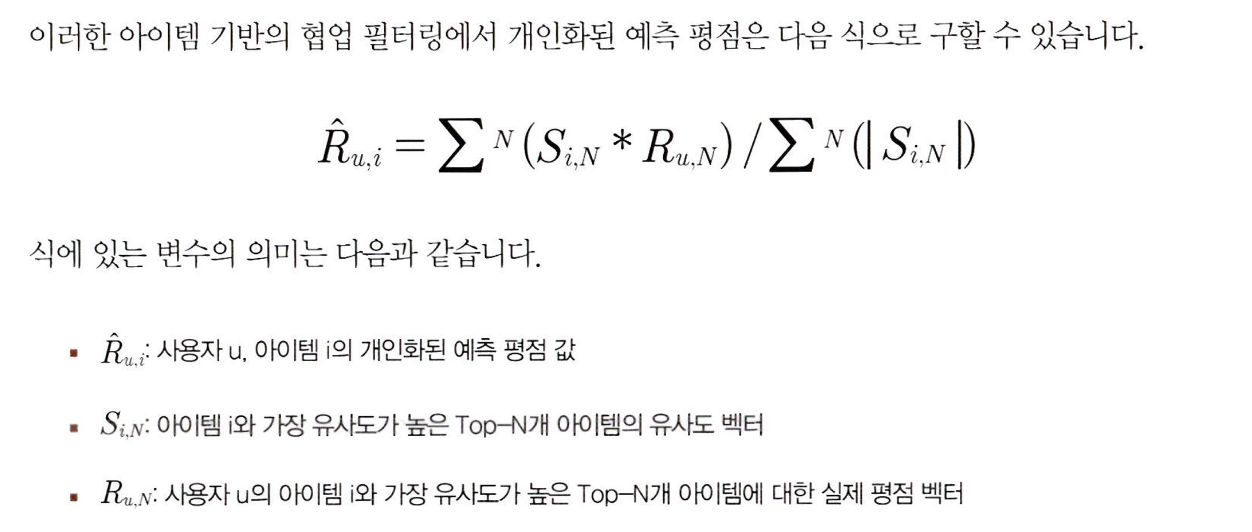

- N 값: 아이템의 최근접 이웃 범위 계수
  - 특정 아이템과 유사도가 가장 높은 Top-N개의 다른 아이템을 추출하는 데 사용됨
- 먼저 N의 범위에 제약을 두지 않고 모든 아이템으로 가정하고 예측 평점을 구하는 로직 작성 -> Top-N 아이템을 기반으로 협업 필터링을 수행하는 로직으로 변경


### 사용자별로 최적화된 평점 스코어 예측

#### 사용자별로 최적화된 평점 스코어를 예측하는 함수 생성
- item_sim_df와 rating_matrix 변수 활용
  - item_sim_df: 영화 간의 유사도를 가지는 DF
  - rating_matrix: 사용자-영화 평점 DF
- 함수명: predict_rating( )
- 인자: 사용자-영화 평점 넘파이 행렬(rating_matrix를 넘파이 행렬로 변환), 영화간의 유사도를 가지는 넘파이 행렬(item_sim_df를 넘파이 행렬로 변환)
- 예측 평점 식으로 개인화된 예측 평점을 계산
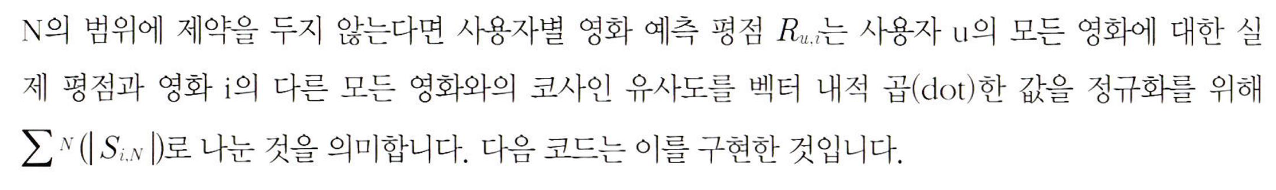

In [14]:
def predict_rating(ratings_arr, item_sim_arr):
  ratings_pred = ratings_arr.dot(item_sim_arr)/ np.array([np.abs(item_sim_arr).sum(axis=1)])
  return ratings_pred

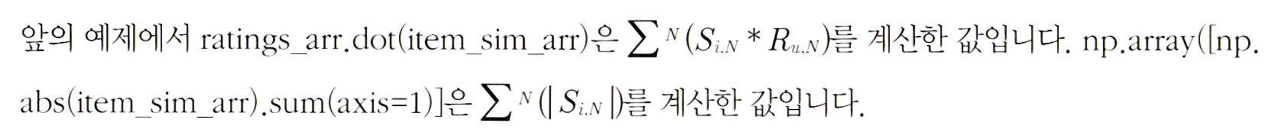

#### 생성한 함수를 이용하여 개인화된 예측 평점 구하기
- ratings_matrix와 item_sim_df를 넘파이 행렬로 변환해 인자로 입력

In [15]:
ratings_pred = predict_rating(ratings_matrix.values, item_sim_df.values)
ratings_pred_matrix = pd.DataFrame(data = ratings_pred, index = ratings_matrix.index, columns = ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501


#### 예측 평가
- 예측 평점이 사용자별 영화의 실제 평점과 영화의 코사인 유사도를 내적한 값이기 때문에 영화를 관람하지 않아 0에 해당했던 실제 영화 평점이 예측에서는 값이 부여되는 경우가 발생

  -> 예측 평점이 실제 평점에 비해 작을 수 있음. 이는 내적 결과를 코사인 유사도 벡터 합으로 나누었기 때문에 생기는 현상

- 예측 결과가 원래의 실제 평점과 얼마나 차이가 있는지 확인
  - 예측 평가 지표: MSE
  - 사용자가 영화의 평점을 주지 않은 경우 앞에서는 평점을 0으로 부여했음
  - 개인화된 예측 점수는 평점을 주지 않은 영화에 대해서도 아이템 유사도에 기반해 평점을 예측했음

  - => 실제와 예측 평점의 차이는 기존에 평점이 부여된 데이터에 대해서만 오차 정도를 측정
  - 예측 평가 지표인 MSE를 계산하는 get_mse( ) 함수를 만들고 결과를 확인

In [16]:
from sklearn.metrics import mean_squared_error

# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 MSE를 구함
def get_mse(pred, actual):
  # 평점이 있는 실제 영화만 추출
  pred = pred[actual.nonzero()].flatten()
  actual = actual[actual.nonzero()].flatten()
  return mean_squared_error(pred, actual)

print('아이템 기반 모든 최근접 이웃 MSE: ', get_mse(ratings_pred, ratings_matrix.values))

아이템 기반 모든 최근접 이웃 MSE:  9.895354759094706


### 특정 영화와 가장 비슷한 유사도를 가지는 영화에 대해서만 추천

#### 특정 영화와 가장 비슷한 유사도를 가지는 영화에 대해서만 유사도 벡터를 적용하는 함수 생성
- 앞의 predict_rating( ) 함수: 사용자별 영화의 예측 평점을 계산하기 위해 해당 영화와 다른 모든 영화 간의 유사도 벡터를 적용한 것
  
  => 많은 영화의 유사도 벡터를 이용
  
  => 상대적으로 평점 예측이 떨어짐

  => 특정 영화와 가장 비슷한 유사도를 가지는 영화에 대해서만 유사도 벡터를 적용하는 함수로 변경
- predict_rating_topsim(ratings_arr, item_sim_arr, n = 20) 함수
  - N 인자를 가지고 있어서 TOP-N 유사도를 가지는 영화 유사도 벡터만 예측값을 계산하는 데 적용
  - 계산을 위해서는 개별 예측값을 구해야하기 때문에 행, 열 별로 for 루프를 반복 수행하며 TOP-N 유사도 벡터 계산

    => 수행시간이 오래 걸림


In [17]:
def predict_rating_topsim(ratings_arr, item_sim_arr, n = 20):
  # 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
  pred = np.zeros(ratings_arr.shape)

  # 사용자-아이템 평점 행렬의 열 크기만큼 루프 수행
  for col in range(ratings_arr.shape[1]):
    # 유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬의 인덱스 반환
    top_n_items = [np.argsort(item_sim_arr[:, col])[:-n-1:-1]]

    # 개인화된 예측 평점을 계산
    for row in range(ratings_arr.shape[0]):
      pred[row, col] = item_sim_arr[col, :][top_n_items].dot(ratings_arr[row, :][top_n_items].T)
      pred[row, col] /= np.sum(np.abs(item_sim_arr[col, :][top_n_items]))

  return pred

#### 예측 평점 계산, MSE
- 계산된 예측 평점 넘파이 행렬은 판다스 DF로 재생성

In [18]:
ratings_pred = predict_rating_topsim(ratings_matrix.values, item_sim_df.values, n = 20)
print('아이템 기반 최근접 TOP-20 이웃 MSE: ', get_mse(ratings_pred, ratings_matrix.values))

# 계산된 예측 평점 데이터는 DataFrame으로 재생성
ratings_pred_matrix = pd.DataFrame(data = ratings_pred, index = ratings_matrix.index, columns = ratings_matrix.columns)

<ipython-input-17-d0821bf4dc2b>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred[row, col] = item_sim_arr[col, :][top_n_items].dot(ratings_arr[row, :][top_n_items].T)


아이템 기반 최근접 TOP-20 이웃 MSE:  3.6949827608772314


#### 특정 사용자에 대해 영화 추천
- 9번 userId 사용자에 대해 영화 추천
  1. 9번 사용자가 어떤 영화를 좋아하는지 확인: 사용자가 평점을 준 영화를 평점이 높은 순으로 나열
  2. 이 사용자에게 아이템 기반 협업 필터링을 통해 영화 추천

    2-1. 사용자가 이미 평점을 준 영화를 제외하고 추천할 수 있도록, 평점을 주지 않은 영화를 리스트 객체로 반환하는 함수인 get_unseen_movies( ) 생성

    2-2. 사용자가 영화의 평점을 주지 않은 추천 대상 영화와 predict_rating_topsim( )에서 추출한 사용자별 아이템 유사도에 기반한 예측 평점 데이터 세트를 이용해 최종적으로 사용자에게 영화를 추천하는 함수인 recomm_movie_by_user( ) 생성

In [19]:
# 1. 9번 사용자가 어떤 영화를 좋아하는지 확인: 사용자가 평점을 준 영화를 평점이 높은 순으로 나열

user_rating_id = ratings_matrix.loc[9, :]
user_rating_id[user_rating_id > 0].sort_values(ascending = False)[:10]

,9
title,
Adaptation (2002),5.0
Citizen Kane (1941),5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),5.0
"Producers, The (1968)",5.0
"Lord of the Rings: The Two Towers, The (2002)",5.0
"Lord of the Rings: The Fellowship of the Ring, The (2001)",5.0
Back to the Future (1985),5.0
Austin Powers in Goldmember (2002),5.0
Minority Report (2002),4.0


- 대작 영화, 어드벤처 영화, 코미디 영화 등 전반적으로 흥행성이 좋은 영화에 높은 평점을 줌

In [20]:
# 2-1. 사용자가 이미 평점을 준 영화를 제외하고 추천할 수 있도록, 평점을 주지 않은 영화를 리스트 객체로 반환하는 함수인 get_unseen_movies( ) 생성

def get_unseen_movies(ratings_matrix, userId):
  # userId로 입력받은 사용자의 모든 영화 정보를 추출해 Series로 반환
  # 반환된 user_rating은 영화명(title)을 인덱스로 가지는 Series 객체임
  user_rating = ratings_matrix.loc[userId, :]

  # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 인덱스를 추출해 list 객체로 만듬
  already_seen = user_rating[user_rating > 0].index.tolist()

  # 모든 영화명을 list 객체로 만듬
  movies_list = ratings_matrix.columns.tolist()

  # list comprehemsion으로 already_seen에 해당하는 영화는 movies_list에서 제외
  unseen_list = [movie for movie in movies_list if movie not in already_seen]

  return unseen_list

In [21]:
# 2-2. 사용자가 영화의 평점을 주지 않은 추천 대상 영화와 predict_rating_topsim( )에서 추출한 사용자별 아이템 유사도에 기반한 예측 평점 데이터 세트를 이용해 최종적으로 사용자에게 영화를 추천하는 함수인 recomm_movie_by_user( ) 생성
## 인자: 예측 평점 DF, 추천하려는 사용자 id, 추천 후보 영화 리스트, 추천 상위 영화 개수
## 출력: 사용자가 좋아할 만한 가장 높은 예측 평점을 가진 영화

def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n = 10):
  # 예측 평점 DataFrame에서 사용자id 인덱스와 unseen_list로 들어온 영화명 칼럼을 추출해 가장 예측 평점이 높은 순으로 정렬
  recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending = False)[:top_n]
  return recomm_movies

# 사용자가 관람하지 않는 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 최근접 이웃 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n = 10)

# 평점 데이터를 DF로 생성
recomm_movies = pd.DataFrame(data = recomm_movies.values, index = recomm_movies.index, columns = ['pred_score'])
recomm_movies

,pred_score
title,
Shrek (2001),0.866202
Spider-Man (2002),0.857854
"Last Samurai, The (2003)",0.817473
Indiana Jones and the Temple of Doom (1984),0.816626
"Matrix Reloaded, The (2003)",0.800990
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.765159
Gladiator (2000),0.740956
"Matrix, The (1999)",0.732693
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.689591


# 9.7. 행렬 분해를 이용한 잠재 요인 협업 필터링 실습
- 행렬 분해 잠재 요인 협업 필터링
  - SVD, NMF 등 적용
  - 일반적으로 행렬 분해에는 SVD가 자주 사용
  - 사용자-아이템 평점 행렬에는 사용자가 평점을 매기지 않은 null 데이터가 많기 때문에 주로 SGD나 ALS 기반의 행렬 분해를 이용
  - 여기서는 SGD 기반의 행렬 분해 구현, 영화 추천

## 4절의 get_rmse( ) 함수 사용

In [33]:
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)

    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)

    return rmse

## 행렬 분해 로직을 새로운 matrix_factorization( ) 함수로 정리
- matrix_factorization(R,K,steps=200,learning_rate=0.01,r_lambda=0.01)
  - R: 원본 사용자-아이템 평점 행렬
  - K: 잠재 요인의 차원 수
  - steps: SGD의 반복 횟수
  - learning_rate: 학습률
  - r_lambda: L2 규제 계수

In [34]:
def matrix_factorization(R,K,steps=200,learning_rate=0.01,r_lambda=0.01):
    num_users,num_items=R.shape

    #P와 Q 매트릭스의 크기를 지정하고 정규 분포를 가진 랜덤한 값으로 입력
    np.random.seed(1)
    P=np.random.normal(scale=1./K,size=(num_users,K))
    Q=np.random.normal(scale=1./K,size=(num_items,K))

    prev_rmse=10000
    break_count=0

    #R>0인 행, 열 위치, 값을 non_zero 리스트 객체에 저장
    non_zeros=[(i,j,R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j]>0]

    #SGD 기법으로 P,Q matrix를 계속 업데이트
    for step in range(steps):
        for i,j,r in non_zeros:
            #실제값과 예측값 차이인 오류값 구하기
            eij=r-np.dot(P[i,:],Q[j,:].T)

            #정규화를 반영한 SGD 업데이트 공식 적용
            P[i,:]=P[i,:]+learning_rate*(eij*Q[j,:]-r_lambda*P[i,:])
            Q[j,:]=Q[j,:]+learning_rate*(eij*P[i,:]-r_lambda*Q[j,:])

        rmse=get_rmse(R, P, Q, non_zeros)

        if(step%10)==0:
            print("### iteration step :", step, " rmse: ", rmse)
    return P,Q

## 영화 평점 행렬 데이터를 사용자-아이템 평점 행렬로 생성
- 영화 평점 행렬 데이터를 새롭게 DF로 로딩 -> 사용자-아이템 평점 행렬로 생성

In [35]:
import pandas as pd
import numpy as np

movies=pd.read_csv('/content/movies.csv')
ratings=pd.read_csv('/content/ratings.csv')
ratings=ratings[['userId','movieId','rating']]
ratings_matrix=ratings.pivot_table('rating',index='movieId',columns='movieId')

# title 칼럼을 얻기 위해 movies와 조인 수행
ratings_movies=pd.merge(ratings,movies,on='movieId')

#columns='title'로 title 칼럼으로 pivot 수행
ratings_matrix=ratings_movies.pivot_table('rating',index='movieId',columns='title')

## 행렬 분해
- 다시 만들어진 사용자-아이템 평점 행렬을 matrix_factorization( ) 함수를 이용해 행렬 분해
- 수행 시간이 오래 걸리므로 SGD 반복횟수인 steps는 200회만 지정
- K = 50, L2 Regularization 계수 = 0.01 설정

In [36]:
P,Q=matrix_factorization(ratings_matrix.values,K=50,steps=200,learning_rate=0.01,r_lambda=0.01)
pred_matrix=np.dot(P,Q.T)

### iteration step : 0  rmse:  3.3745305538773867
### iteration step : 10  rmse:  3.359962839538086
### iteration step : 20  rmse:  3.3353937960908264
### iteration step : 30  rmse:  3.287119580013948
### iteration step : 40  rmse:  3.188960175697435
### iteration step : 50  rmse:  2.999934953055246
### iteration step : 60  rmse:  2.6842216825334426
### iteration step : 70  rmse:  2.2567331943484645
### iteration step : 80  rmse:  1.7896616636795306
### iteration step : 90  rmse:  1.36311369208508
### iteration step : 100  rmse:  1.0210300220038908
### iteration step : 110  rmse:  0.7669582241020713
### iteration step : 120  rmse:  0.5844966327516745
### iteration step : 130  rmse:  0.45397853509526637
### iteration step : 140  rmse:  0.3594576144952893
### iteration step : 150  rmse:  0.28987583246960613
### iteration step : 160  rmse:  0.2379319898852414
### iteration step : 170  rmse:  0.19868316494423963
### iteration step : 180  rmse:  0.16862496601086513
### iteration step : 190 

## 반환된 사용자-아이템 평점 행렬의 칼럼명 변경
- 더 쉽게 영화 아이템 칼럼을 이해하기 위해 반환된 예측 사용자-아이템 평점 행렬을 영화 타이틀을 칼럼명으로 가지는 DF로 변경

In [37]:
rating_pred_matrix=pd.DataFrame(data=pred_matrix,index=ratings_matrix.index,columns=ratings_matrix.columns)
rating_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
movieId,,,,,,,,,,,,,,,,,,,,,
1,-0.758233,-0.052356,-0.756763,-1.068458,0.374390,-0.347095,0.827393,-0.348838,0.247671,0.165586,...,-0.083644,-0.280219,0.280893,-0.156348,0.324372,-0.386604,-0.145946,0.163610,0.461678,-0.184093
2,0.262478,-0.133071,-0.110659,-0.374049,0.441585,0.384656,0.082095,-0.342185,-0.832278,0.166675,...,-0.034726,0.476649,-0.534565,-0.631697,-0.044196,0.994124,-0.419517,-0.418244,-0.037347,-0.222577
3,-0.252080,-0.460726,0.082015,-0.547901,-0.177238,0.049936,0.103018,-0.651234,-0.200584,0.634052,...,0.134994,0.321515,-0.246105,-0.767090,-0.169077,-0.434571,-0.253952,-0.422882,0.876640,0.192177


## 개인화된 영화 추천

In [ ]:
# 2-1. 사용자가 이미 평점을 준 영화를 제외하고 추천할 수 있도록, 평점을 주지 않은 영화를 리스트 객체로 반환하는 함수인 get_unseen_movies( ) 생성

def get_unseen_movies(ratings_matrix, userId):
  # userId로 입력받은 사용자의 모든 영화 정보를 추출해 Series로 반환
  # 반환된 user_rating은 영화명(title)을 인덱스로 가지는 Series 객체임
  user_rating = ratings_matrix.loc[userId, :]

  # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 인덱스를 추출해 list 객체로 만듬
  already_seen = user_rating[user_rating > 0].index.tolist()

  # 모든 영화명을 list 객체로 만듬
  movies_list = ratings_matrix.columns.tolist()

  # list comprehemsion으로 already_seen에 해당하는 영화는 movies_list에서 제외
  unseen_list = [movie for movie in movies_list if movie not in already_seen]

  return unseen_list

# 2-2. 사용자가 영화의 평점을 주지 않은 추천 대상 영화와 predict_rating_topsim( )에서 추출한 사용자별 아이템 유사도에 기반한 예측 평점 데이터 세트를 이용해 최종적으로 사용자에게 영화를 추천하는 함수인 recomm_movie_by_user( ) 생성
## 인자: 예측 평점 DF, 추천하려는 사용자 id, 추천 후보 영화 리스트, 추천 상위 영화 개수
## 출력: 사용자가 좋아할 만한 가장 높은 예측 평점을 가진 영화

def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n = 10):
  # 예측 평점 DataFrame에서 사용자id 인덱스와 unseen_list로 들어온 영화명 칼럼을 추출해 가장 예측 평점이 높은 순으로 정렬
  recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending = False)[:top_n]
  return recomm_movies

# 사용자가 관람하지 않는 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 최근접 이웃 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n = 10)

# 평점 데이터를 DF로 생성
recomm_movies = pd.DataFrame(data = recomm_movies.values, index = recomm_movies.index, columns = ['pred_score'])
recomm_movies

In [27]:
#사용자가 관람하지 않은 영화명 추출
unseen_list=get_unseen_movies(ratings_matrix,9)

#잠재 요인 협업 필터링으로 영화 추천
recomm_movies=recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

#평점 데이터를 df로 생성
recomm_movies=pd.DataFrame(data=recomm_movies.values,index=recomm_movies.index,columns=['pred_score'])
recomm_movies

,pred_score
title,
Body of Evidence (1993),2.967085
Blind Date (1984),2.967085
"Last Seduction, The (1994)",1.837418
Sunshine State (2002),1.210886
Back to the Future Part III (1990),1.177924
Back to the Future Part II (1989),1.146718
"Lord of the Rings: The Fellowship of the Ring, The (2001)",1.118403
Back to the Future (1985),1.018926
"Producers, The (1968)",1.002248
